# **DCGAN hands generator**

DCGAN original paper: [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434) *by Alec Radford, Luke Metz, Soumith Chintala*

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import time
import zipfile
import urllib.request
from IPython import display

## 1. Dataset
Dataset consists of hands image of sizes 28x28. The files are downloaded as .zip, extracted and then preprocessed into Tensorflow Dataset.

### 1.1 Load dataset

In [2]:
DATASET_DOWNLOAD_URL = "https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/signs-training.zip"
ZIP_DIR = "signs-training.zip"
DATASET_DIR = '/dataset'

urllib.request.urlretrieve(DATASET_DOWNLOAD_URL, ZIP_DIR)

with zipfile.ZipFile(ZIP_DIR, 'r') as unpack:
    unpack.extractall(DATASET_DIR)

### 1.2 Preprocess the dataset
Images are decoded and normalized.

In [3]:
BATCH_SIZE = 32

def load_and_preprocess(file):
    img = tf.io.decode_png(tf.io.read_file(file))
    img = tf.dtypes.cast(img, tf.float32)
    img = img / 255.0
    return img


dataset_filenames = tf.data.Dataset.list_files("/dataset/signs-training/*.png")

dataset = dataset_filenames.map(load_and_preprocess)

print(f'Number of records: {dataset.cardinality().numpy()}')
print(f'Image dimensions: {next(iter(dataset)).shape}')

dataset = dataset.batch(BATCH_SIZE)

Number of records: 27455
Image dimensions: (28, 28, 1)


### 1.3 Preview the dataset

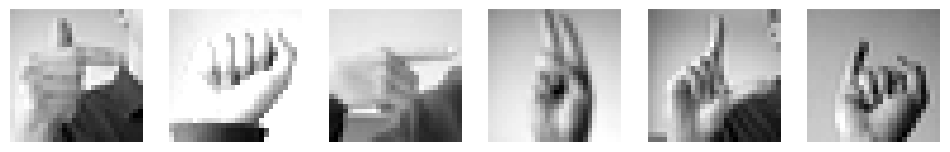

In [4]:
PREVIEW_AMOUNT = 6

for images in dataset.take(1):
    
    fig, axs = plt.subplots(1, PREVIEW_AMOUNT, figsize=(12,2))

    for i in range(PREVIEW_AMOUNT):
        axs[i].axis('off')
        axs[i].imshow(images[i], cmap='gray')

## 2. Model

### 2.1 Custom Spectral Normalization wrapper layer

Spectral normalization is used on discriminator to improve stability of learning (Lipschitz Continuity).

In [5]:
@tf.keras.utils.register_keras_serializable()
class SpectralNormalization(tf.keras.layers.Wrapper):
    def __init__(self, layer, iteration=1,**kwargs):
        super(SpectralNormalization, self).__init__(layer, **kwargs)
        self.iteration = iteration

    def build(self, input_shape):
        super(SpectralNormalization, self).build(input_shape)
        self.w = self.layer.kernel
        self.w_shape = self.w.shape.as_list()
        self.u = self.add_weight(shape=(1, self.w_shape[-1]),
                                 initializer=tf.initializers.RandomNormal(),
                                 trainable=False,
                                 
                                 dtype=tf.float32)

    def call(self, inputs):
        self.normalize_weights()
        output = self.layer(inputs)
        return output

    def normalize_weights(self):
        w = tf.reshape(self.w, [-1, self.w_shape[-1]])
        u_hat = self.u
        v_hat = None

        for _ in range(self.iteration):
            v_ = tf.matmul(u_hat, tf.transpose(w))
            v_hat = tf.nn.l2_normalize(v_)

            u_ = tf.matmul(v_hat, w)
            u_hat = tf.nn.l2_normalize(u_)

        sigma = tf.matmul(tf.matmul(v_hat, w), tf.transpose(u_hat))
        self.u.assign(u_hat)

        self.layer.kernel = self.w / sigma

### 2.1 Generator

In [18]:
def get_generator(input_shape):
    inputs = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(7*7*128)(inputs)
    x = tf.keras.layers.Reshape([7, 7, 128])(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding="SAME", activation="selu")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    y = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=5, strides=2, padding="SAME", activation="tanh")(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=y, name="Generator")
    return model

### 2.2 Discriminator

In [19]:
def get_discriminator(input_shape=[28, 28, 1]):
    inputs = tf.keras.layers.Input(input_shape)
    x = SpectralNormalization(tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME", activation=tf.keras.layers.LeakyReLU(0.2)))(inputs)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = SpectralNormalization(tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME", activation=tf.keras.layers.LeakyReLU(0.2)))(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Flatten()(x)
    y = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=y, name="Discriminator")
    return model

### 2.3 DCGAN
We are testing rmsprop and adam.

In [20]:
def get_DCGAN(generator, discriminator):

    discriminator.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))
    discriminator.trainable = False

    model = tf.keras.models.Sequential([generator, discriminator], name="DCGAN")
    model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))
    return model


random_normal_dimensions = 32

generator = get_generator(random_normal_dimensions)
discriminator = get_discriminator()

generator.summary()
discriminator.summary()

DCGAN = get_DCGAN(generator, discriminator)
DCGAN.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_2 (Dense)             (None, 6272)              206976    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_2 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 128)      409728    
 ranspose)                                                       
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 128)      51

## 3. Train

### 3.1 Training loop function

In [21]:
def train_gan(gan, dataset, random_normal_dimensions, epochs=50):
    generator, discriminator = gan.layers

    discriminator_losses = []
    generator_losses = []

    print(f"Starting training for {epochs} epochs")
    for epoch in range(epochs):

        start_time = time.time()
        
        for real_images in dataset:
            real_batch_size = real_images.shape[0]

            noise = tf.random.normal(shape=[real_batch_size, random_normal_dimensions])

            with tf.GradientTape() as tape:
                fake_images = generator(noise)
                mixed_images = tf.concat([fake_images, real_images], axis=0)
                discriminator_labels = tf.concat([tf.zeros((real_batch_size, 1)), tf.ones((real_batch_size, 1))], axis=0)
                discriminator_loss = discriminator.train_on_batch(mixed_images, discriminator_labels)
                

            noise = tf.random.normal(shape=[real_batch_size, random_normal_dimensions])

            with tf.GradientTape() as tape:
                generator_labels = tf.ones((real_batch_size, 1))
                generator_loss = gan.train_on_batch(noise, generator_labels)

        discriminator_losses.append(discriminator_loss)  
        generator_losses.append(generator_loss)

        epoch_time = time.time() - start_time

        print(f"Epoch {epoch+1} / {epochs}\tTime: {epoch_time:.2f}s")
        print(f"Discriminator_loss: {discriminator_loss:.5f}\t Generator_loss: {generator_loss:.5f}")
        plot_results(fake_images, 16)
        plt.show()

    return {"discriminator_loss": discriminator_losses, "generator_loss": generator_losses}

### 3.2 Run the training

In [22]:
def plot_results(images, n_cols=None):   
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    
    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Starting training for 30 epochs
Epoch 1 / 30	Time: 40.95s
Discriminator_loss: 0.68816	 Generator_loss: 0.65818


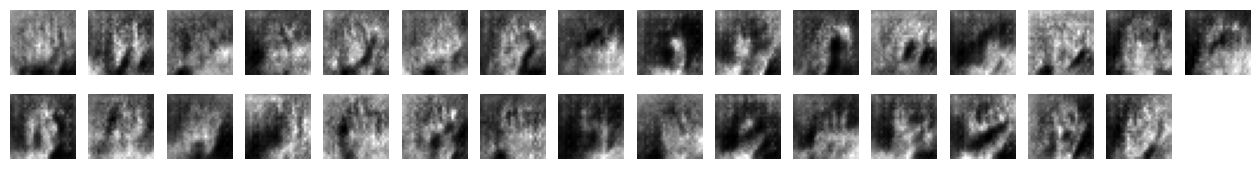

Epoch 2 / 30	Time: 31.88s
Discriminator_loss: 0.68006	 Generator_loss: 0.71201


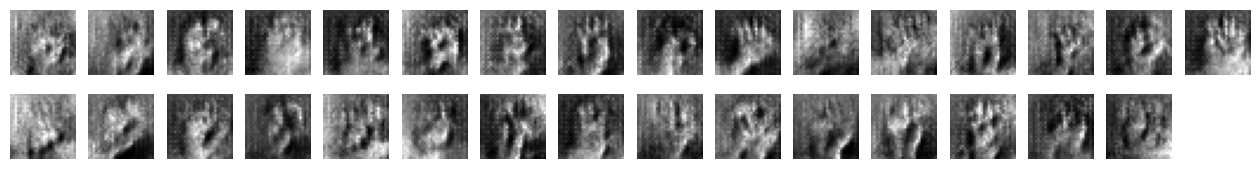

Epoch 3 / 30	Time: 40.95s
Discriminator_loss: 0.66572	 Generator_loss: 0.88708


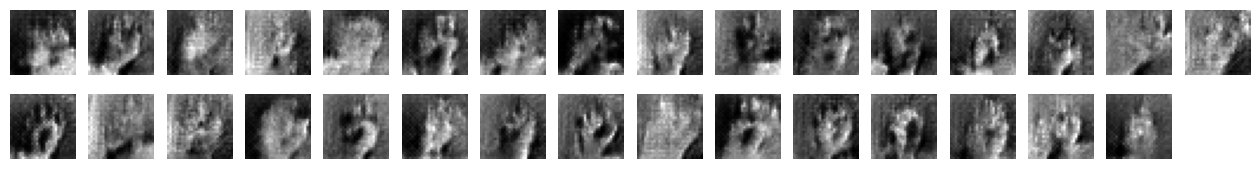

Epoch 4 / 30	Time: 31.39s
Discriminator_loss: 0.67869	 Generator_loss: 0.98642


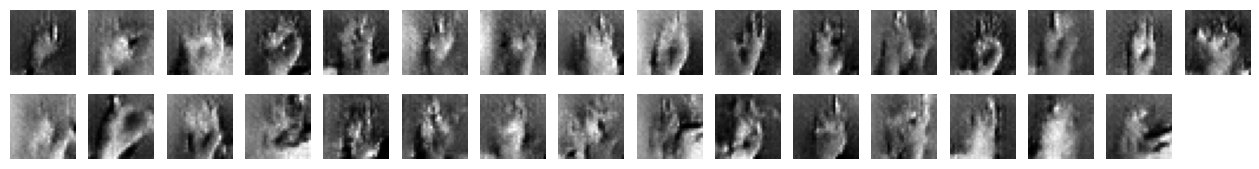

Epoch 5 / 30	Time: 40.96s
Discriminator_loss: 0.63431	 Generator_loss: 0.90672


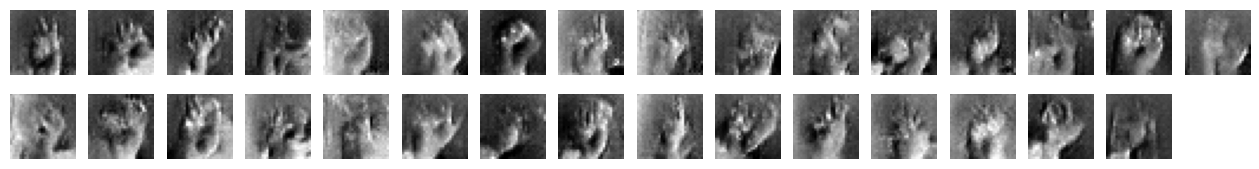

Epoch 6 / 30	Time: 40.95s
Discriminator_loss: 0.64175	 Generator_loss: 0.98627


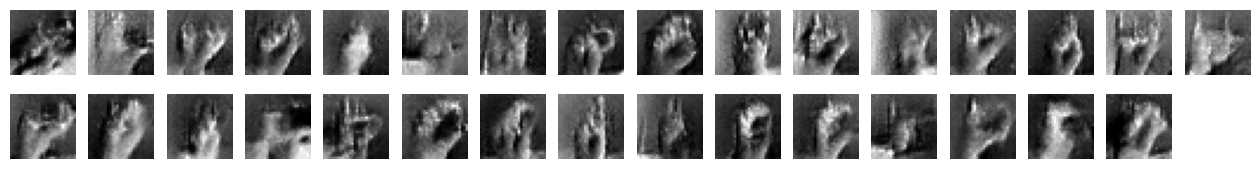

Epoch 7 / 30	Time: 31.96s
Discriminator_loss: 0.60901	 Generator_loss: 0.84904


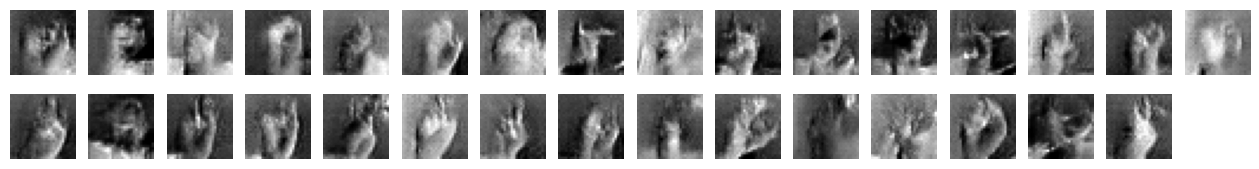

Epoch 8 / 30	Time: 40.95s
Discriminator_loss: 0.69704	 Generator_loss: 0.72417


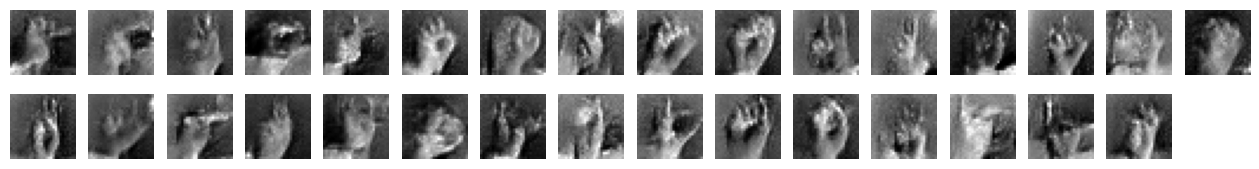

Epoch 9 / 30	Time: 31.47s
Discriminator_loss: 0.61317	 Generator_loss: 0.85501


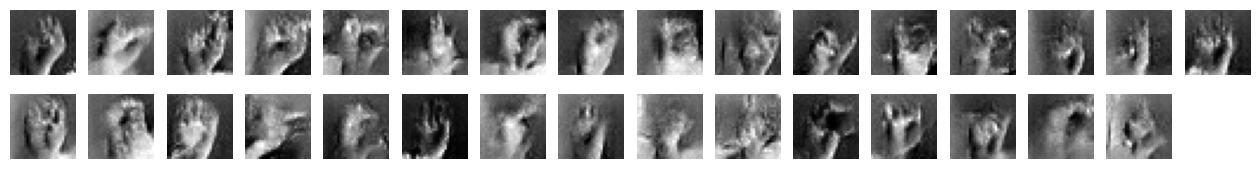

Epoch 10 / 30	Time: 31.94s
Discriminator_loss: 0.62807	 Generator_loss: 0.77949


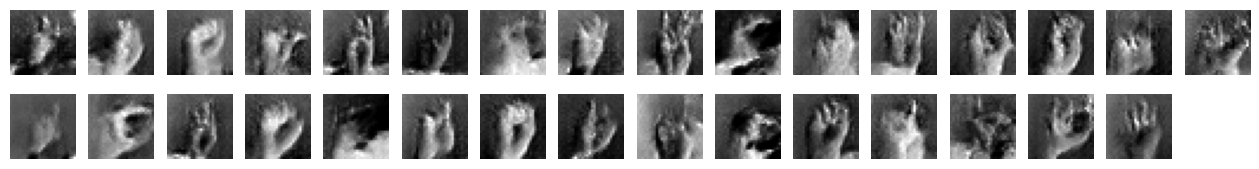

Epoch 11 / 30	Time: 32.40s
Discriminator_loss: 0.59088	 Generator_loss: 0.69756


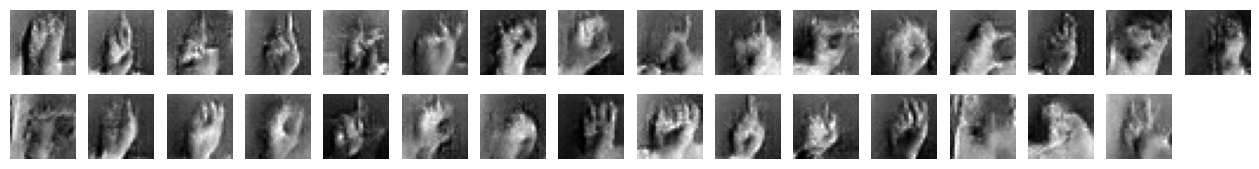

Epoch 12 / 30	Time: 40.96s
Discriminator_loss: 0.58527	 Generator_loss: 0.73576


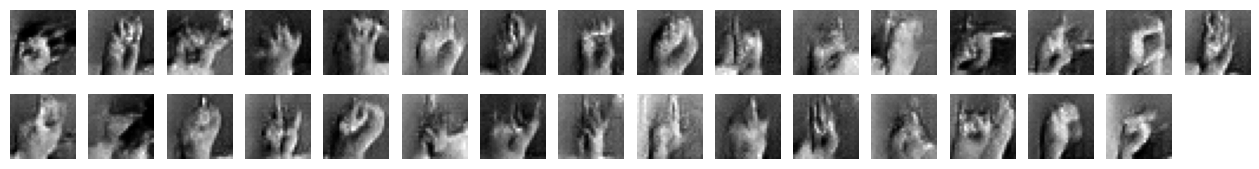

Epoch 13 / 30	Time: 40.95s
Discriminator_loss: 0.61095	 Generator_loss: 1.05286


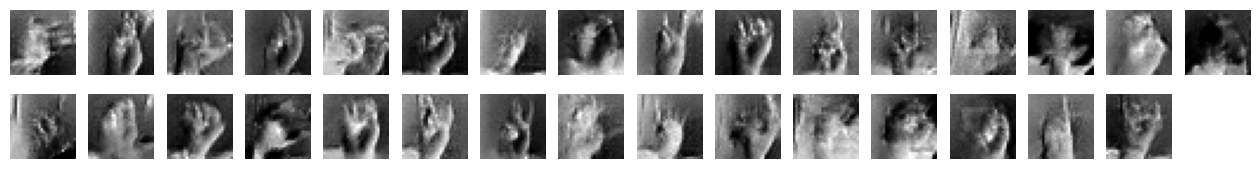

Epoch 14 / 30	Time: 31.41s
Discriminator_loss: 0.57326	 Generator_loss: 0.65515


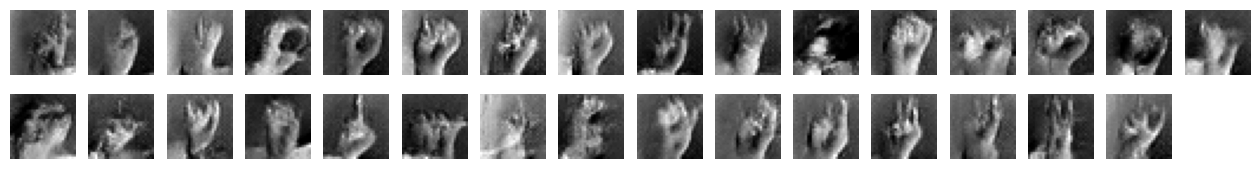

Epoch 15 / 30	Time: 40.95s
Discriminator_loss: 0.57955	 Generator_loss: 0.78624


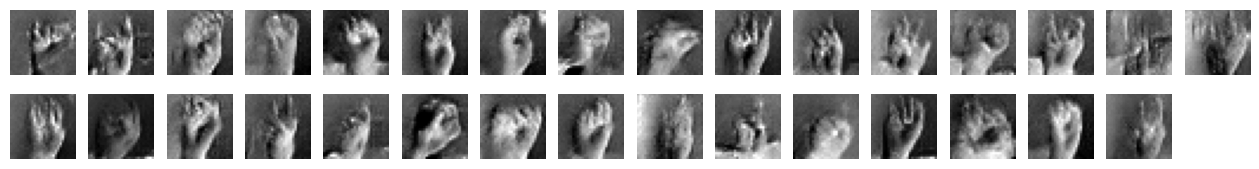

Epoch 16 / 30	Time: 32.16s
Discriminator_loss: 0.64168	 Generator_loss: 1.09450


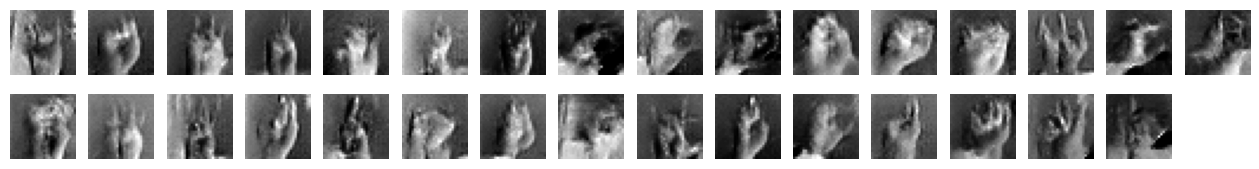

Epoch 17 / 30	Time: 32.65s
Discriminator_loss: 0.59640	 Generator_loss: 0.76634


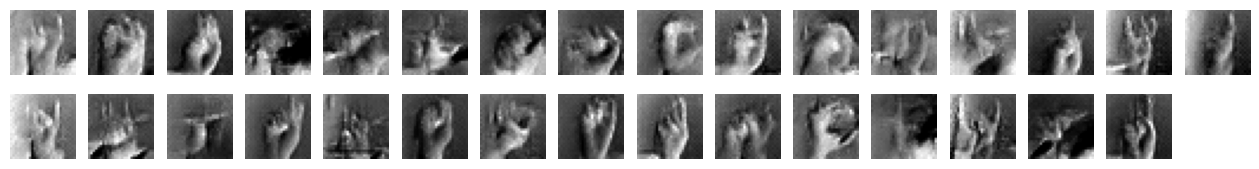

Epoch 18 / 30	Time: 32.51s
Discriminator_loss: 0.64422	 Generator_loss: 0.72408


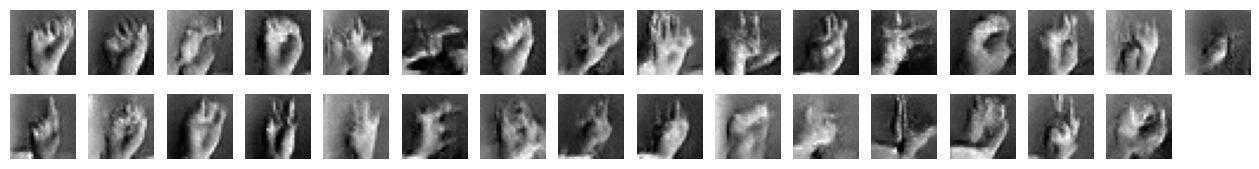

Epoch 19 / 30	Time: 32.26s
Discriminator_loss: 0.54564	 Generator_loss: 0.84681


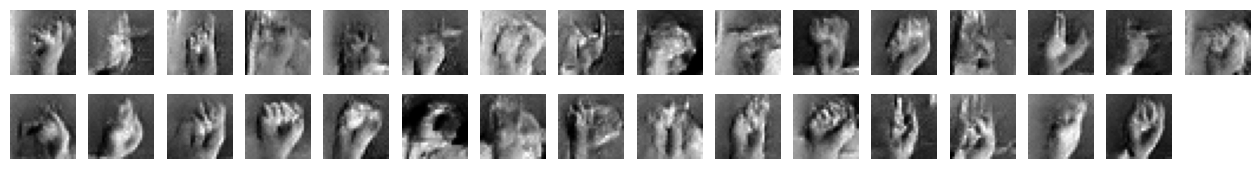

Epoch 20 / 30	Time: 31.81s
Discriminator_loss: 0.54120	 Generator_loss: 0.72127


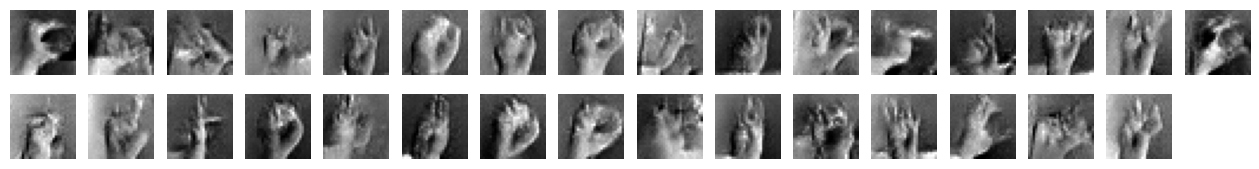

Epoch 21 / 30	Time: 40.96s
Discriminator_loss: 0.58094	 Generator_loss: 0.66854


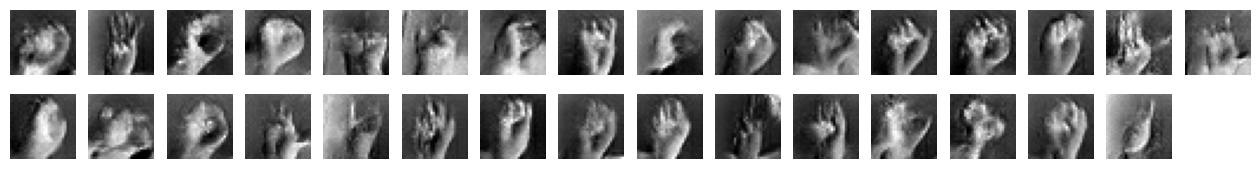

Epoch 22 / 30	Time: 33.01s
Discriminator_loss: 0.58760	 Generator_loss: 0.78542


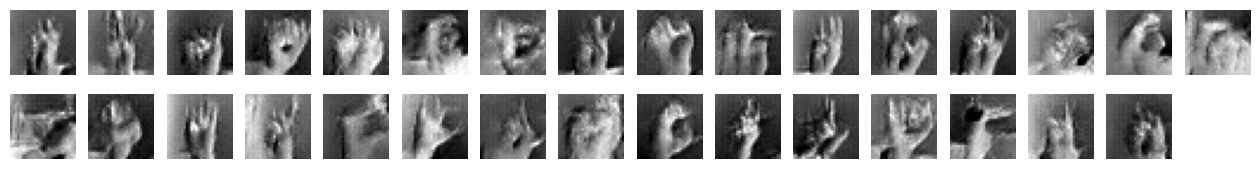

Epoch 23 / 30	Time: 40.95s
Discriminator_loss: 0.51395	 Generator_loss: 1.01216


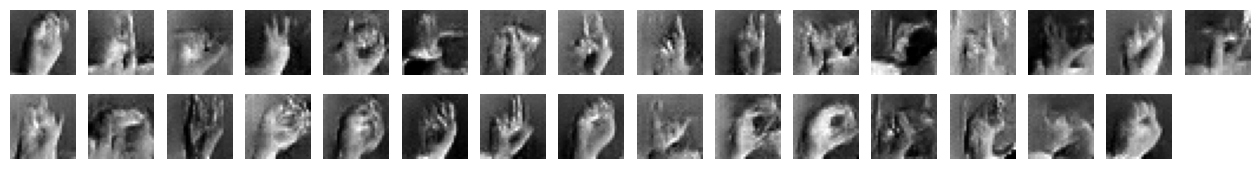

Epoch 24 / 30	Time: 32.06s
Discriminator_loss: 0.60778	 Generator_loss: 1.61616


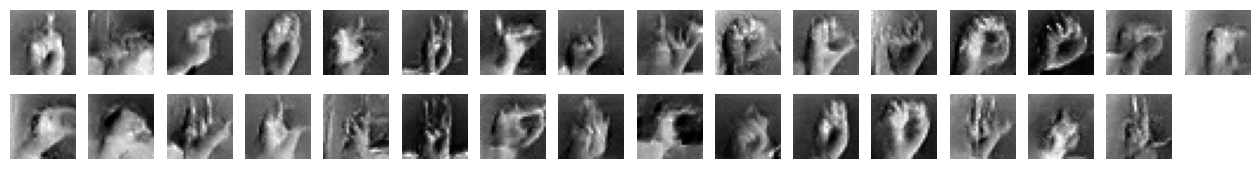

Epoch 25 / 30	Time: 33.00s
Discriminator_loss: 0.51603	 Generator_loss: 0.98522


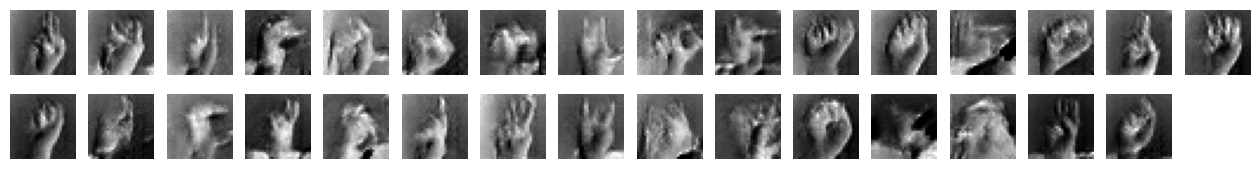

Epoch 26 / 30	Time: 32.81s
Discriminator_loss: 0.55211	 Generator_loss: 1.12959


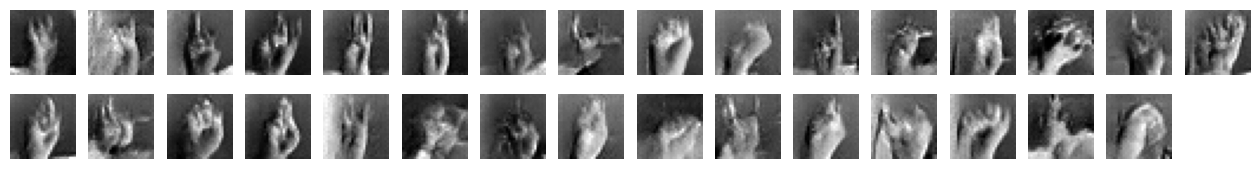

Epoch 27 / 30	Time: 40.97s
Discriminator_loss: 0.48919	 Generator_loss: 0.78031


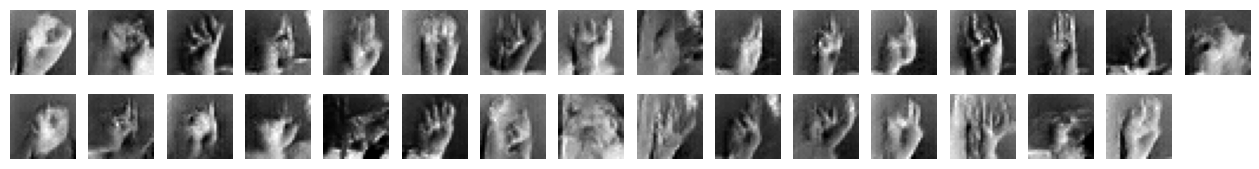

Epoch 28 / 30	Time: 32.44s
Discriminator_loss: 0.56284	 Generator_loss: 0.87566


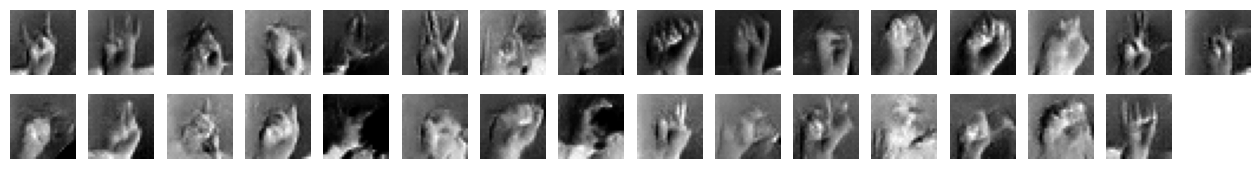

Epoch 29 / 30	Time: 31.76s
Discriminator_loss: 0.54567	 Generator_loss: 0.82261


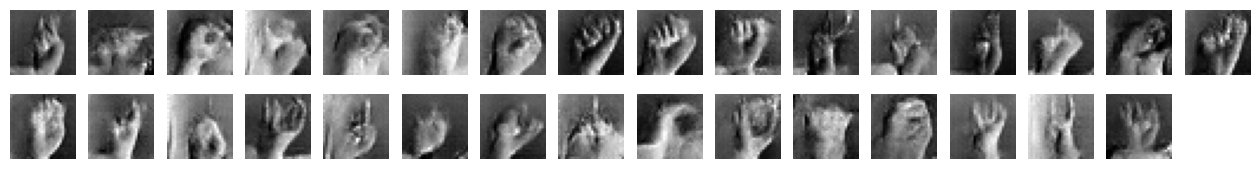

Epoch 30 / 30	Time: 32.93s
Discriminator_loss: 0.62099	 Generator_loss: 1.01260


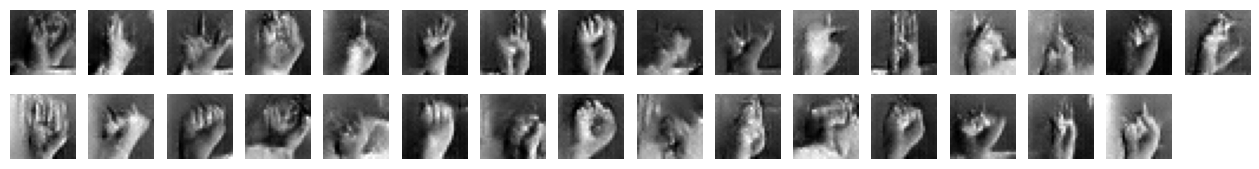

In [23]:
EPOCHS = 30

metrics = train_gan(DCGAN, dataset, random_normal_dimensions, EPOCHS)

## 4. Evaluate

### 4.1 Model loss history

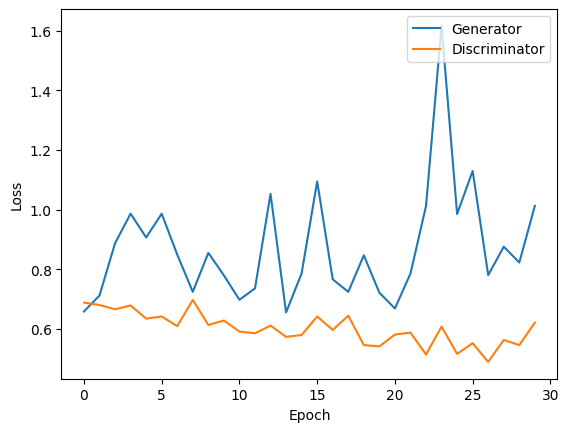

In [24]:
plt.plot(np.arange(EPOCHS), metrics["generator_loss"])
plt.plot( np.arange(EPOCHS), metrics["discriminator_loss"])
plt.ylabel('Loss')
plt.xlabel("Epoch")
plt.legend(['Generator', 'Discriminator'], loc="upper right")
plt.show()

### 4.2 Generate some results

In [25]:
def generate_images(amount=1):
    noise = tf.random.normal(shape=[amount, random_normal_dimensions])
    fake_images = generator(noise)
    return fake_images

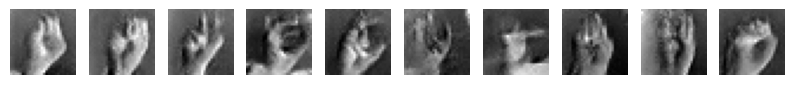

In [42]:
images = generate_images(10)
plot_results(images, 10)

## 5. Save the model

In [27]:
DCGAN.save('model/hands_generator.h5')